In [38]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
import warnings
import itertools
from sfp_nsdsyn.bootstrapping import pooled_std, standardized_mean, calculate_permutation_metric
warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
results_dir = os.path.join(output_dir, 'sfp_model', 'results_2D')
fig_dir = os.path.join(output_dir, 'figures')
lr = 0.0005
max_epoch = 30000
roi_list = ['V1']
vsc='pRFsize'
nsd_subj_list = [utils.sub_number_to_string(sn, 'nsdsyn') for sn in np.arange(1,9)]
broderick_sn_list = [1, 6, 7, 45, 46, 62, 64, 81, 95, 114, 115, 121]
broderick_subj_list = [utils.sub_number_to_string(i, 'broderick') for i in broderick_sn_list]
ARGS_2D = ['sub','lr','eph','roi']
roi_pal = [sns.color_palette('dark', 10)[:][k] for k in  [3,2,0]]
roi_pal.insert(0, (0.3,0.3,0.3))
stim_classes=['annulus', 'pinwheel', 'forward spiral','reverse spiral']
goal='replication'

In [4]:
pt_file_list = []
for subj, roi in itertools.product(nsd_subj_list, ['V1']):
    file_name = os.path.join(output_dir, 'sfp_model', 'results_2D', 'nsdsyn', 
                             f'model-params_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-{roi}_vs-{vsc}.pt')
    pt_file_list.append(file_name)
nsd_params = model.load_all_models(pt_file_list, *ARGS_2D)

nsd_precision_s =  pd.read_csv(os.path.join(output_dir, 'dataframes', 'nsdsyn', 'precision',f'precision-s_dset-nsdsyn_vs-pRFsize.csv'))
nsd_df = pd.merge(nsd_params, nsd_precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])
nsd_df['dset_type'] = nsd_df['vroinames'].apply(lambda x: f'NSD {x}')


In [5]:
pt_file_list = []
for subj, roi in itertools.product(broderick_subj_list, ['V1']):
    file_name = os.path.join(output_dir,'sfp_model', 'results_2D', 'broderick',f'model-params_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-{roi}_vs-{vsc}.pt')
    pt_file_list.append(file_name)
broderick_params = model.load_all_models(pt_file_list, *ARGS_2D)

broderick_precision_s =  pd.read_csv(os.path.join(output_dir, 'dataframes', 'broderick', 'precision', f'precision-s_dset-broderick_vs-pRFsize.csv'))
broderick_df = pd.merge(broderick_params, broderick_precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])
broderick_df['dset_type'] = 'Broderick et al. V1'


In [ ]:
final_params = pd.concat((broderick_df, nsd_df), axis=0)
# pooled_sd_df = pooled_std(final_params, group_col='dset_type')
# std_mean_df = standardized_mean(final_params, pooled_sd_df, group_col='dset_type')
# params = ['sigma', 'slope', 'intercept', 'p_1', 'p_2', 'p_3', 'p_4', 'A_1', 'A_2']
# x1 = std_mean_df.query('dset_type == "Broderick et al. V1"')[params].to_numpy().squeeze()
# x2 = std_mean_df.query('dset_type == "NSD V1"')[params].to_numpy().squeeze()
# data_r = utils.pearson_r(x1, x2)
# print(f'corr between NSD V1 and Broderick et al.: {data_r :.3f}')


corr between NSD V1 and Broderick et al.: 0.965


In [6]:
null_nsd_params = pd.DataFrame({})
n_permutations = 100
for p in range(n_permutations):
    null_r_list = []
    for subj, roi in itertools.product(nsd_subj_list, ['V1']):
        file_name = os.path.join(output_dir, 'sfp_model', 'results_2D', 'nsdsyn', 'perm',
                                f'perm-{p}_model-params_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-{roi}_vs-{vsc}.pt')
        null_r_list.append(file_name)
    null_tmp_nsd_params = model.load_all_models(null_r_list, *['sub','lr','eph','roi','perm'])
    null_nsd_params = pd.concat((null_nsd_params, null_tmp_nsd_params), axis=0)
null_nsd_df = pd.merge(null_nsd_params, nsd_precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])
null_nsd_df['dset_type'] = null_nsd_df['vroinames'].apply(lambda x: f'Null NSD {x}')
null_nsd_df['perm'] = null_nsd_df['perm'].astype(int)

In [44]:
params = ['sigma', 'slope', 'intercept', 'p_1', 'p_2', 'p_3', 'p_4', 'A_1', 'A_2']

# Create broderick_df_melt with mean values per parameter
broderick_df_melt = broderick_df.melt(id_vars=['dset_type', 'sub'], value_vars=params, var_name='parameter', value_name='value')
broderick_df_melt = broderick_df_melt.groupby(['dset_type', 'parameter']).mean().reset_index()

# Create nsd_df_melt for plotting
nsd_df_melt = nsd_df.melt(id_vars=['dset_type', 'sub'], value_vars=params, var_name='parameter', value_name='value')
nsd_df_melt = nsd_df_melt.groupby(['dset_type', 'parameter']).mean().reset_index()

# Calculate MSE for each permutation and parameter (compared to overall mean)
null_mse_df = bts.calculate_mse(null_nsd_df, groupby='perm', params=params, metric='mse')
nsd_mse_df = bts.calculate_mse(nsd_df, groupby='dset_type', params=params, metric='mse')
broderick_mse_df = bts.calculate_mse(broderick_df, groupby='dset_type', params=params, metric='mse')


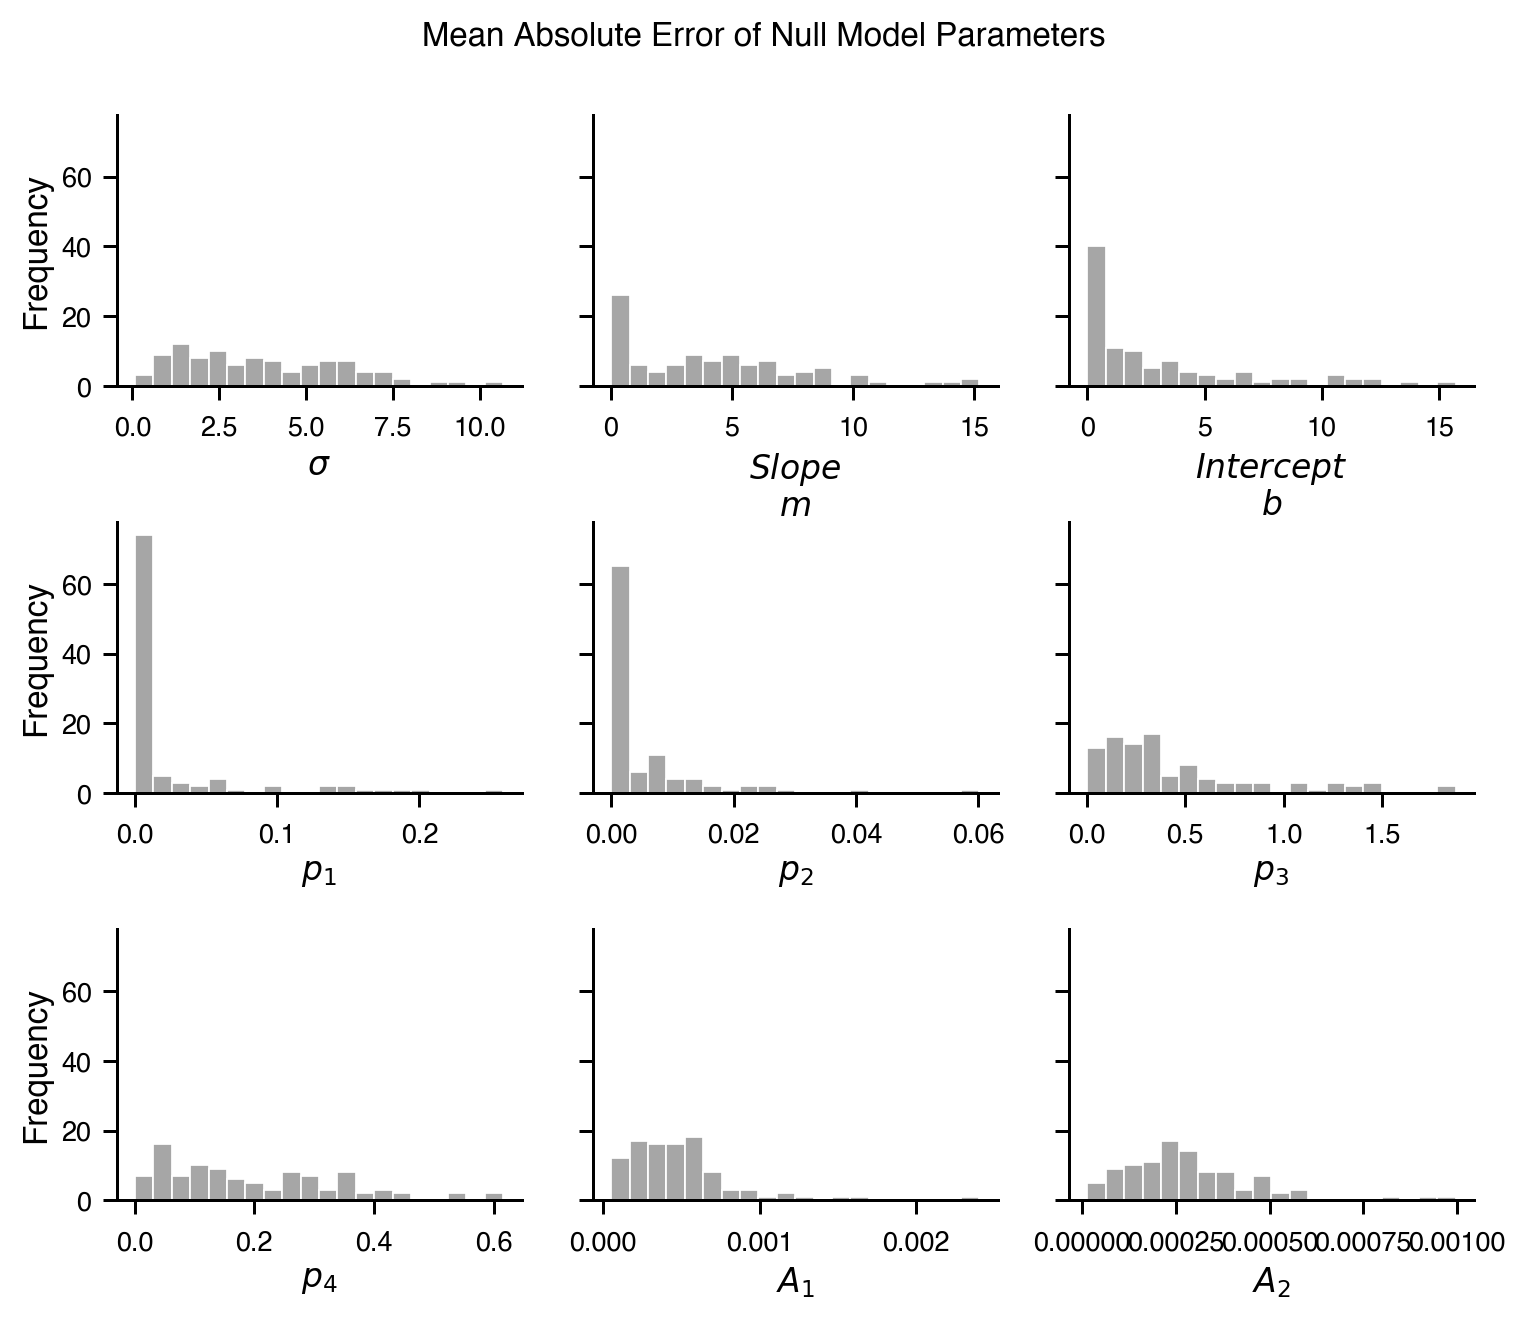

In [46]:
null_nsd_df_melted = null_nsd_df.melt(id_vars=['dset_type', 'sub', 'perm'], 
                                      value_vars=params, 
                                      var_name='parameter', 
                                      value_name='value')
vis2D.plot_null_parameter_distributions(null_mse_df, value='value', real_df=None,
                                        title='Mean Absolute Error of Null Model Parameters',)

In [16]:
null_nsd_df_melted

,dset_type,sub,perm,parameter,value
0,Null NSD V1,subj01,0,sigma,8.344556
1,Null NSD V1,subj01,1,sigma,9.978989
2,Null NSD V1,subj01,2,sigma,4.567024
3,Null NSD V1,subj01,3,sigma,5.099609
4,Null NSD V1,subj01,4,sigma,9.119332
...,...,...,...,...,...
7195,Null NSD V1,subj08,95,A_2,0.016722
7196,Null NSD V1,subj08,96,A_2,-0.005632
7197,Null NSD V1,subj08,97,A_2,-0.006345
7198,Null NSD V1,subj08,98,A_2,0.009345


In [98]:
null_nsd_df_melted.query('parameter == "slope"').min()

dset_type    Null NSD V1
sub               subj01
perm                   0
parameter          slope
value          -1.192362
dtype: object

In [94]:
perm_r_list = []
for p in range(n_permutations):
    null_tmp_df = null_nsd_df.query(f'perm == {p}')
    df = pd.concat((broderick_df, null_tmp_df), axis=0)
    perm_std_mean_df = standardized_mean(df, pooled_sd_df, group_col='dset_type')
    x1 = perm_std_mean_df.query('dset_type == "Broderick et al. V1"')[params].to_numpy().squeeze()
    x2 = perm_std_mean_df.query('dset_type == "Null NSD V1"')[params].to_numpy().squeeze()
    perm_r_list.append(utils.pearson_r(x1, x2))
    

(<Figure size 864x648 with 1 Axes>,
 <AxesSubplot:xlabel='Correlation coefficient', ylabel='Frequency'>)

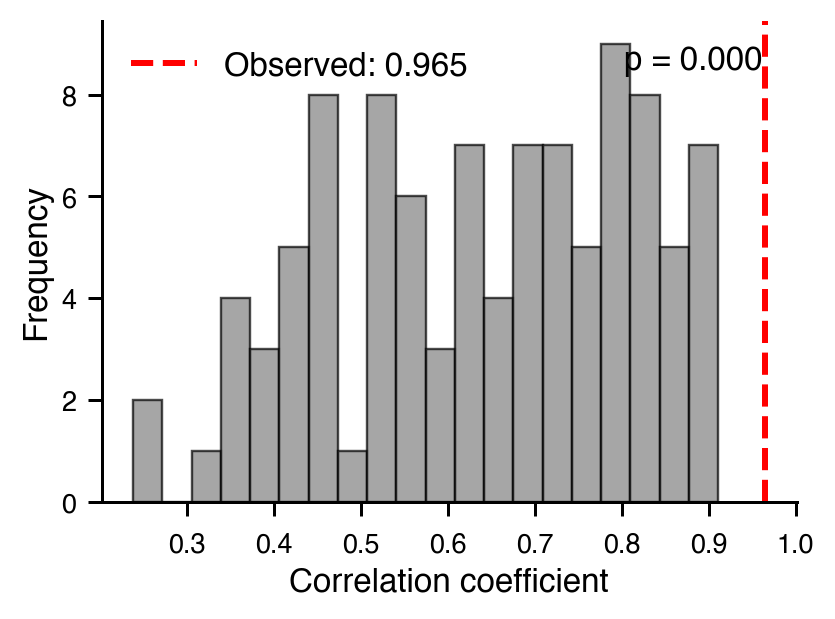

In [95]:
vis2D.plot_null_distribution_histogram(perm_r_list, data_r, bins=20)